### ML Classification Models

#### Models to Test
- Random Forest Classifier [RandomForestClassifier]
- XGBoost [GradientBoostingClassifier]
- Logistic Regression [LogisticRegression]
- Linear Regression [LinearRegression]
- CART (Classsification and Regression Trees) [tree.DecisionTreeClassifier]


In [106]:
# Basic packages
import numpy as np
import pandas as pd
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns

#Models
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.metrics import classification_report,confusion_matrix

# Explainability
import lime
import lime.lime_tabular
import shap
import joblib

### Load Data and Divide into Disease-Specific DataFrames

In [2]:
# Import Data and Create DataFrames
all_labs = pd.read_csv('/Users/emmadyer/Desktop/PROJECTS/private_data/ind_all_labs_imputed.csv')

# Drop values with insufficient data for external validation
all_labs = all_labs.drop(columns=all_labs.filter(regex='pro|uac|vtd|pmn|ast', axis=1))

# IBD and Healthy Patients
# Healthy-0, IBD-1
ibd_vs_healthy = all_labs.copy()
ibd_vs_healthy['ibd_disease_code'] = ibd_vs_healthy['ibd_disease_code'].replace([2], 1)
ibd_vs_healthy = ibd_vs_healthy.drop('patient_id', axis=1)

# UC and CD Patients
# UC-0, CD-1
uc_vs_cd = all_labs.copy()
ibd_codes = [1,2]
uc_vs_cd = uc_vs_cd[uc_vs_cd['ibd_disease_code'].isin(ibd_codes)]
uc_vs_cd['ibd_disease_code'] = uc_vs_cd['ibd_disease_code'].replace([2], 0)
uc_vs_cd = uc_vs_cd.drop('patient_id', axis=1)

# CD and Healthy Patients
# Healthy-0, CD-1
cd_vs_healthy = all_labs.copy()
cd_healthy_codes = [1,0]
cd_vs_healthy = cd_vs_healthy[cd_vs_healthy['ibd_disease_code'].isin(cd_healthy_codes)]
cd_vs_healthy = cd_vs_healthy.drop('patient_id', axis=1)

# UC and Healthy Patients
# Healthy-0, UC-1
uc_vs_healthy = all_labs.copy()
uc_healthy_codes = [2,0]
uc_vs_healthy = uc_vs_healthy[uc_vs_healthy['ibd_disease_code'].isin(uc_healthy_codes)]
uc_vs_healthy['ibd_disease_code'] = uc_vs_healthy['ibd_disease_code'].replace([2], 1)
uc_vs_healthy = uc_vs_healthy.drop('patient_id', axis=1)

In [3]:
all_healthy = all_labs.loc[all_labs['ibd_disease_code']==0]

### Random Forest Classifier (with CRP)

In [76]:
# X = data to train on 
# y = outcome of interest ('target')

X = ibd_vs_healthy.iloc[:, :-1]
X = X.fillna(0)
y = ibd_vs_healthy.loc[:, 'ibd_disease_code']
X_col_names = list(ibd_vs_healthy.columns.values)
X_col_names = X_col_names[:-1]
y_col_name = ['disease_code']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [77]:
# Random Forest Classifier


# Identify the best number of trees
# n_estimators = list(range(10,1000,50))
# Best Number of Estimators: 160
# Best Number of Max Features: 9

n_estimators = list(range(1,20,1))

rfcs = []
for n in n_estimators:
    rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=9)
    rfc.fit(X_train, y_train)
    rfcs.append(rfc)

train_accuracy = [rfc.score(X_train, y_train) for rfc in rfcs]
test_accuracy = [rfc.score(X_test, y_test) for rfc in rfcs]

# Identify where the test error is minimized
best_n_estimators = n_estimators[np.argmax(test_accuracy)]
rfc_best_train_accuracy = train_accuracy[np.argmax(test_accuracy)]
rfc_best_test_accuracy = test_accuracy[np.argmax(test_accuracy)]

print(f"The n_estimators value that maximizes the test set accuracy is: {best_n_estimators}")
print("Train Accuracy: ", rfc_best_train_accuracy)
print("Test Accuracy: ", rfc_best_test_accuracy)

# Save the model
joblib.dump(rfc, '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/random_forest_classifier_with_CRP.joblib')


The n_estimators value that maximizes the test set accuracy is: 1
Train Accuracy:  1.0
Test Accuracy:  0.9578494623655914


['/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/random_forest_classifier_with_CRP.joblib']

In [53]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns.tolist(),
                                                  class_names=rfc.classes_.tolist(), 
                                                  verbose=True, 
                                                  mode='classification',
                                                  random_state=42)

In [91]:
# X_test indices corresponding to specific outcomes
ibd = [100, 66, 68,239, 27]
healthy = [30, 15, 543, 354, 21]
together = ibd + healthy

In [ ]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, 
                                                   feature_names=X_train.columns.tolist(),
                                                  class_names=rfc.classes_.tolist(), 
                                                  verbose=True, 
                                                  mode='classification',
                                                  random_state=42)
# Choose the 5th instance and use it to predict the results
for j in together:
    exp = explainer.explain_instance(X_test.iloc[j], rfc.predict_proba, num_features=10)
    exp.show_in_notebook(show_table=True)
    exp.save_to_file(f'/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/explanations/random_forest_crp_explanations_{j}.html')

    prediction = rfc.predict(X_test.iloc[j].to_frame().T)
    print(f"Predicted value: {prediction[0]}")
    print(f"True value: {y_test.iloc[j]}")

In [6]:
rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=9)
rfc.fit(X_train, y_train)
feat_imp_df = pd.DataFrame({'feature': X_col_names
                              ,'importance': rfc.feature_importances_})\
                            .sort_values('importance', ascending=False)



### Feature Importance IBD vs. Healthy (with CRP)

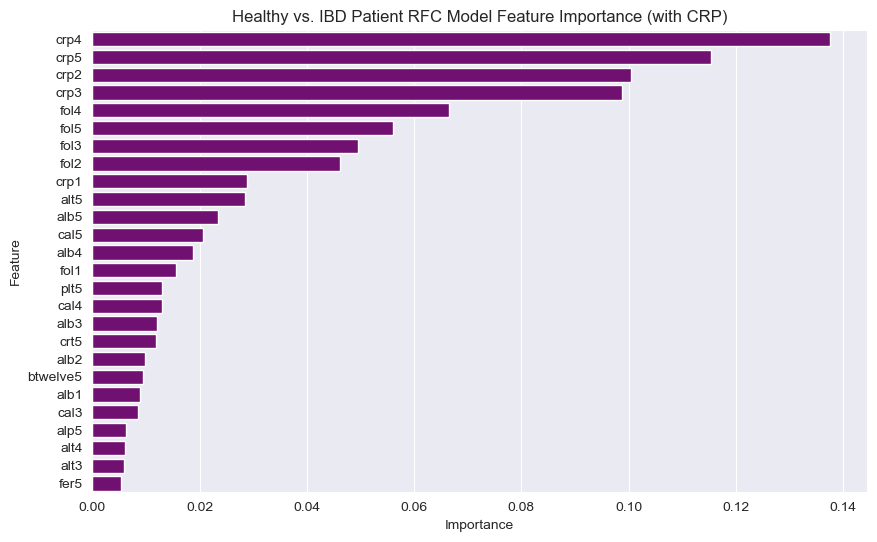

In [7]:
df = ibd_vs_healthy

X = df.iloc[:, :-1]
X = X.fillna(0)
y = df.loc[:, 'ibd_disease_code']
X_col_names = list(df.columns.values)
X_col_names = X_col_names[:-1]
y_col_name = ['disease_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
rfc.fit(X_train, y_train)

feat_imp_df = pd.DataFrame({'feature': X_col_names
                              ,'importance': rfc.feature_importances_})\
                            .sort_values('importance', ascending=False)


sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
important_feats = feat_imp_df.sort_values('importance', ascending=False).reset_index()
important_feats = important_feats.loc[:25, :]
l = sns.barplot(x=important_feats['importance']
            , y=important_feats['feature']
            , color='purple').set(ylabel= "Feature", xlabel= "Importance", title="Healthy vs. IBD Patient RFC Model Feature Importance (with CRP)")
plt.savefig('/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/healthy_ibd_barplot.png', dpi=300)

### Feature Importance UC vs. CD (with CRP)

In [ ]:
df = uc_vs_cd

X = df.iloc[:, :-1]
X = X.fillna(0)
y = df.loc[:, 'ibd_disease_code']
X_col_names = list(df.columns.values)
X_col_names = X_col_names[:-1]
y_col_name = ['disease_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
rfc.fit(X_train, y_train)

feat_imp_df = pd.DataFrame({'feature': X_col_names
                              ,'importance': rfc.feature_importances_})\
                            .sort_values('importance', ascending=False)

sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
important_feats = feat_imp_df.sort_values('importance', ascending=False).reset_index()
important_feats = important_feats.loc[:25, :]
l = sns.barplot(x=important_feats['importance']
            , y=important_feats['feature']
            , color='green').set(ylabel= "Feature", xlabel= "Importance", title="CD vs. UC Patient RFC Model Feature Importance (with CRP)")
plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/tree_feature_barplots/cd_uc_barplot.png', dpi=300)

### Feature Importance UC vs. Healthy (with CRP)

In [ ]:
df = uc_vs_healthy

X = df.iloc[:, :-1]
X = X.fillna(0)
y = df.loc[:, 'ibd_disease_code']
X_col_names = list(df.columns.values)
X_col_names = X_col_names[:-1]
y_col_name = ['disease_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
rfc.fit(X_train, y_train)

feat_imp_df = pd.DataFrame({'feature': X_col_names
                              ,'importance': rfc.feature_importances_})\
                            .sort_values('importance', ascending=False)

sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
important_feats = feat_imp_df.sort_values('importance', ascending=False).reset_index()
important_feats = important_feats.loc[:25, :]
l = sns.barplot(x=important_feats['importance']
            , y=important_feats['feature']
            , color='blue').set(ylabel= "Feature", xlabel= "Importance", title="UC vs. Healthy Patient RFC Model Feature Importance (with CRP)")
plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/tree_feature_barplots/uc_healthy_barplot.png', dpi=300)

### Feature Importance CD vs. Healthy (with CRP)

In [ ]:
df = cd_vs_healthy

X = df.iloc[:, :-1]
X = X.fillna(0)
y = df.loc[:, 'ibd_disease_code']
X_col_names = list(df.columns.values)
X_col_names = X_col_names[:-1]
y_col_name = ['disease_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
rfc.fit(X_train, y_train)

feat_imp_df = pd.DataFrame({'feature': X_col_names
                              ,'importance': rfc.feature_importances_})\
                            .sort_values('importance', ascending=False)

sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
important_feats = feat_imp_df.sort_values('importance', ascending=False).reset_index()
important_feats = important_feats.loc[:25, :]
l = sns.barplot(x=important_feats['importance']
            , y=important_feats['feature']
            , color='pink').set(ylabel= "Feature", xlabel= "Importance", title="CD vs. Healthy Patient RFC Model Feature Importance (with CRP)")
plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/tree_feature_barplots/cd_healthy_barplot.png', dpi=300)

In [ ]:
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_train, y_train)
shap.summary_plot(shap_values, X_train)

In [ ]:
# clean up the shap values to be more readable
shap_val_df = pd.DataFrame(shap_values)
shap_val_df.columns = X_col_names
shap_val_df.head()

### All Random Forest Classifier AUROC (with CRP)

In [ ]:
# Test Random Forest on All Datasets
rfcs = []
all_dfs = [ibd_vs_healthy, uc_vs_cd, cd_vs_healthy, uc_vs_healthy]
names = ['IBD vs. Healthy', 'UC vs. CD', 'CD vs. Healthy', 'UC vs Healthy']
for i, df in enumerate(all_dfs):
    X = df.iloc[:, :-1]
    X = X.fillna(0)
    y = df.loc[:, 'ibd_disease_code']
    X_col_names = list(df.columns.values)
    X_col_names = X_col_names[:-1]
    y_col_name = ['disease_code']

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)
    
    rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
    rfc.fit(X_train, y_train)
    rfcs.append(rfc)
    ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, name=names[i], alpha=0.8)
    #rfc_disp.plot(ax=ax, alpha=0.8)
plt.show()


### Random Forest Classifier (without CRP)

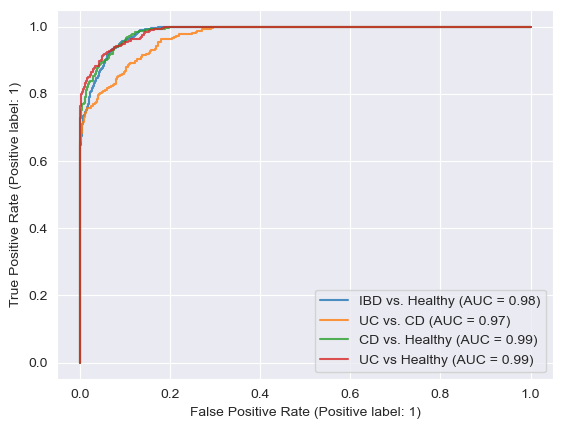

['/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/random_forest_classifier_without_CRP.joblib']

In [93]:
original = [ibd_vs_healthy, uc_vs_cd, cd_vs_healthy, uc_vs_healthy]
all_dfs = []
# Remove CRP
crp_cols = ['crp1', 'crp2', 'crp3', 'crp4', 'crp5']
for df in original:
    df = df.drop(crp_cols, axis=1)
    all_dfs.append(df)

# Test Random Forest on All Datasets
rfcs = []
names = ['IBD vs. Healthy', 'UC vs. CD', 'CD vs. Healthy', 'UC vs Healthy']
for i, df in enumerate(all_dfs):
    X = df.iloc[:, :-1]
    X = X.fillna(0)
    y = df.loc[:, 'ibd_disease_code']
    X_col_names = list(df.columns.values)
    X_col_names = X_col_names[:-1]
    y_col_name = ['disease_code']

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)
    
    rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
    rfc.fit(X_train, y_train)
    rfcs.append(rfc)
    ax = plt.gca()
    rfc_disp = RocCurveDisplay.from_estimator(rfc, X_test, y_test, ax=ax, name=names[i], alpha=0.8)
    #rfc_disp.plot(ax=ax, alpha=0.8)
plt.show()

joblib.dump(rfc, '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/random_forest_classifier_without_CRP.joblib')


In [33]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['disease_code'], verbose=True, mode='regression')

# Choose the 5th instance and use it to predict the results
j = 100
exp = explainer.explain_instance(X_test.iloc[j], rfc.predict, num_features=6)
exp.show_in_notebook(show_table=True)

prediction = rfc.predict(X_test.iloc[j].to_frame().T)
print(f"Predicted value: {prediction[0]}")
print(f"True value: {y_test.iloc[j]}")

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


Intercept 0.33887910294510926
Prediction_local [0.17434832]
Right: 0.14011984004587527


Predicted value: 0.14011984004587527
True value: 0


### Feature Importance IBD vs. Healthy (no CRP)

In [ ]:
df = ibd_vs_healthy.drop(crp_cols, axis=1)

X = df.iloc[:, :-1]
X = X.fillna(0)
y = df.loc[:, 'ibd_disease_code']
X_col_names = list(df.columns.values)
X_col_names = X_col_names[:-1]
y_col_name = ['disease_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
rfc.fit(X_train, y_train)

feat_imp_df = pd.DataFrame({'feature': X_col_names
                              ,'importance': rfc.feature_importances_})\
                            .sort_values('importance', ascending=False)

sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
important_feats = feat_imp_df.sort_values('importance', ascending=False).reset_index()
important_feats = important_feats.loc[:25, :]
l = sns.barplot(x=important_feats['importance']
            , y=important_feats['feature']
            , color='purple').set(ylabel= "Feature", xlabel= "Importance", title="Healthy vs. IBD Patient RFC Model Feature Importance (no CRP)")
plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/tree_feature_barplots/nocrp_healthy_ibd_barplot.png', dpi=300)

### Feature Importance UC vs. CD (no CRP)

In [ ]:
df = uc_vs_cd.drop(crp_cols, axis=1)

X = df.iloc[:, :-1]
X = X.fillna(0)
y = df.loc[:, 'ibd_disease_code']
X_col_names = list(df.columns.values)
X_col_names = X_col_names[:-1]
y_col_name = ['disease_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
rfc.fit(X_train, y_train)

feat_imp_df = pd.DataFrame({'feature': X_col_names
                              ,'importance': rfc.feature_importances_})\
                            .sort_values('importance', ascending=False)

sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
important_feats = feat_imp_df.sort_values('importance', ascending=False).reset_index()
important_feats = important_feats.loc[:25, :]
l = sns.barplot(x=important_feats['importance']
            , y=important_feats['feature']
            , color='green').set(ylabel= "Feature", xlabel= "Importance", title="CD vs. UC Patient RFC Model Feature Importance (no CRP)")
plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/tree_feature_barplots/nocrp_cd_uc_barplot.png', dpi=300)

### UC vs. Healthy (no CRP)

In [ ]:
df = uc_vs_healthy.drop(crp_cols, axis=1)

X = df.iloc[:, :-1]
X = X.fillna(0)
y = df.loc[:, 'ibd_disease_code']
X_col_names = list(df.columns.values)
X_col_names = X_col_names[:-1]
y_col_name = ['disease_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
rfc.fit(X_train, y_train)

feat_imp_df = pd.DataFrame({'feature': X_col_names
                              ,'importance': rfc.feature_importances_})\
                            .sort_values('importance', ascending=False)

sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
important_feats = feat_imp_df.sort_values('importance', ascending=False).reset_index()
important_feats = important_feats.loc[:25, :]
l = sns.barplot(x=important_feats['importance']
            , y=important_feats['feature']
            , color='blue').set(ylabel= "Feature", xlabel= "Importance", title="UC vs. Healthy Patient RFC Model Feature Importance (no CRP)")
plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/tree_feature_barplots/nocrp_uc_healthy_barplot.png', dpi=300)

### CD vs. Healthy (no CRP)

In [ ]:
df = cd_vs_healthy.drop(crp_cols, axis=1)

X = df.iloc[:, :-1]
X = X.fillna(0)
y = df.loc[:, 'ibd_disease_code']
X_col_names = list(df.columns.values)
X_col_names = X_col_names[:-1]
y_col_name = ['disease_code']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
rfc.fit(X_train, y_train)

feat_imp_df = pd.DataFrame({'feature': X_col_names
                              ,'importance': rfc.feature_importances_})\
                            .sort_values('importance', ascending=False)

sns.set_style('darkgrid')
plt.figure(figsize=(10, 6))
important_feats = feat_imp_df.sort_values('importance', ascending=False).reset_index()
important_feats = important_feats.loc[:25, :]
l = sns.barplot(x=important_feats['importance']
            , y=important_feats['feature']
            , color='pink').set(ylabel= "Feature", xlabel= "Importance", title="CD vs. Healthy Patient RFC Model Feature Importance (no CRP)")
plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/tree_feature_barplots/nocrp_cd_healthy_barplot.png', dpi=300)

In [ ]:
df = uc_vs_healthy

X = df.iloc[:, :-1]
X = X.fillna(0)
y = df.loc[:, 'ibd_disease_code']
X_col_names = list(df.columns.values)
X_col_names = X_col_names[:-1]
y_col_name = ['disease_code']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)



In [ ]:
ibd_train = len(y_train[y_train == 1])
healthy_train = len(y_train[y_train == 0])
print("IBD Patients in Training Data: ", ibd_train)
print("Healthy Patients in Training Data: ", healthy_train)

ibd_test = len(y_test[y_test == 1])
healthy_test = len(y_test[y_test == 0])
print("IBD Patients in Testing Data: ", ibd_test)
print("Healthy Patients in Testing Data: ", healthy_test)


### Model Comparisons

In [100]:
def test_models(df, 
                plot_title, 
                fig_name_path,
                model_save_path):
    X = df.iloc[:, :-1]
    X = X.fillna(0)
    y = df.loc[:, 'ibd_disease_code']
    X_col_names = list(df.columns.values)
    X_col_names = X_col_names[:-1]
    y_col_name = ['disease_code']

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

    names = [
        "Nearest Neighbors",
        "Linear SVM",
        "RBF SVM",
        "Logistic Regression",
        "Decision Tree",
        "Random Forest",
        "Neural Net",
        "XGBoost",
        "Naive Bayes",
        "QDA",
    ]

    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        LogisticRegression(penalty='l2', max_iter=100, C=0.05, n_jobs=-1, random_state=42),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, n_jobs=-1),
        MLPClassifier(alpha=1, max_iter=1000),
        HistGradientBoostingClassifier(early_stopping=True, max_depth=5),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
    ]
    i = 0
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        ax = plt.gca()
        # Debugging step: Check the format of X_test and y_test
        print(f"X_test type: {type(X_test)}, shape: {X_test.shape}")
        print(f"y_test type: {type(y_test)}, shape: {y_test.shape}")

        clf_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax, name=names[i], alpha=0.8)
        i+=1
        print(i)
        joblib.dump(clf, model_save_path+f'_{name}.joblib')
    plt.title(plot_title)
    #plt.figure(figsize=(10,6))
    fig = plt.gcf()
    fig.savefig(fig_name_path, dpi=300)

    return



In [102]:
def test_models(df, 
                plot_title, 
                fig_name_path,
                model_save_path):
    X = df.iloc[:, :-1]
    X = X.fillna(0)
    y = df.loc[:, 'ibd_disease_code']
    X_col_names = list(df.columns.values)
    X_col_names = X_col_names[:-1]
    y_col_name = ['disease_code']

    # Train/Test Split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

    names = [
        "Nearest Neighbors",
        "Linear SVM",
        "RBF SVM",
        "Logistic Regression",
        "Decision Tree",
        "Random Forest",
        "Neural Net",
        "XGBoost",
        "Naive Bayes",
        "QDA",
    ]

    classifiers = [
        KNeighborsClassifier(3),
        SVC(kernel="linear", C=0.025),
        SVC(gamma=2, C=1),
        LogisticRegression(penalty='l2', max_iter=100, C=0.05, n_jobs=-1, random_state=42),
        DecisionTreeClassifier(max_depth=5),
        RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1, n_jobs=-1),
        MLPClassifier(alpha=1, max_iter=1000),
        HistGradientBoostingClassifier(early_stopping=True, max_depth=5),
        GaussianNB(),
        QuadraticDiscriminantAnalysis(),
    ]
    i = 0
    for name, clf in zip(names, classifiers):
        clf.fit(X_train, y_train)
        ax = plt.gca()
        
        try:
            clf_disp = RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax, name=names[i], alpha=0.8)
        except Exception as e:
            print(f"Error with classifier {name}: {e}")
            continue
        
        i += 1
        print(i)
        save_path = model_save_path + f'_{name}.joblib'
        save_path = save_path.replace(' ', '_')
        joblib.dump(clf, save_path)
    
    plt.title(plot_title)
    fig = plt.gcf()
    fig.savefig(fig_name_path, dpi=300)

Error with classifier Nearest Neighbors: 'Flags' object has no attribute 'c_contiguous'
1
2
3
4
5
6
7
8
9


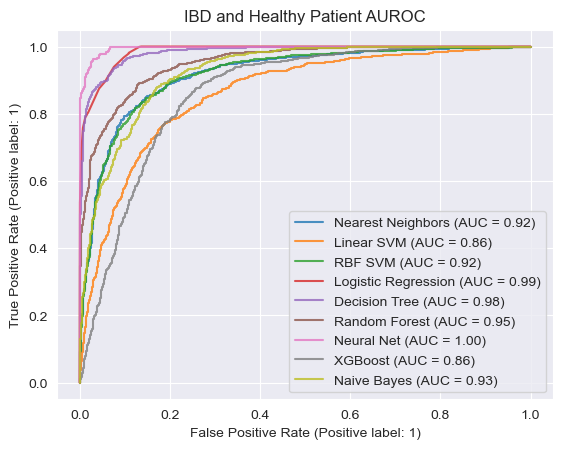

In [104]:
# IBD vs. Healthy (with CRP)
df = ibd_vs_healthy
fig_name_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/healthy_ibd_models.png'
plot_title = 'IBD and Healthy Patient AUROC'
save_model_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/ibd_vs_healthy_with_CRP'


test_models(ibd_vs_healthy, plot_title, fig_name_path, save_model_path)

Error with classifier Nearest Neighbors: 'Flags' object has no attribute 'c_contiguous'
1
2
3
4
5
6
7
8
9


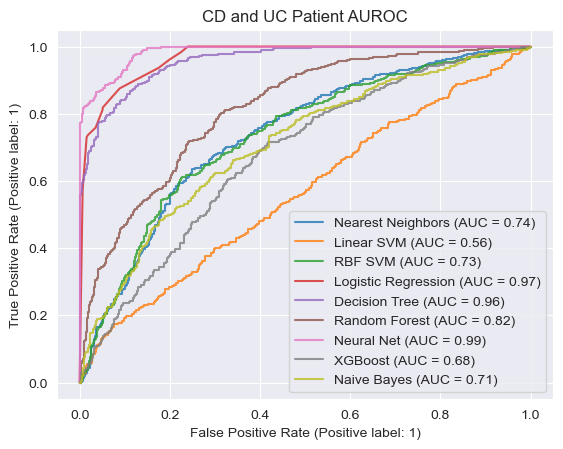

In [105]:
# UC vs. CD (with CRP)
fig_name_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/cd_uc_models.png'
save_model_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/uc_vs_cd_with_CRP'
plot_title = 'CD and UC Patient AUROC'

test_models(uc_vs_cd, plot_title, fig_name_path, save_model_path)

Error with classifier Nearest Neighbors: 'Flags' object has no attribute 'c_contiguous'
1
2
3
4
5
6
7
8
9


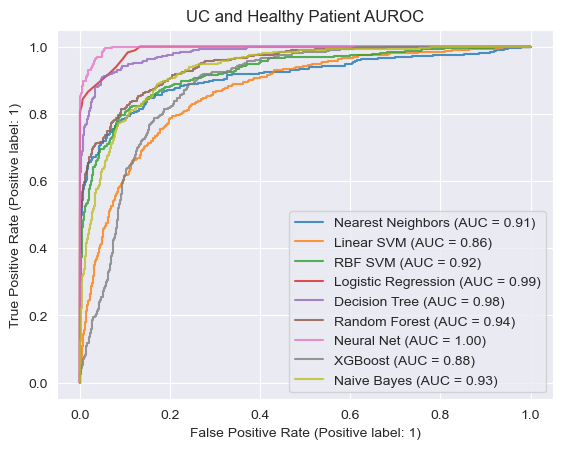

In [107]:
# UC vs. Healthy (with CRP)
fig_name_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/uc_healthy_models.png'
plot_title = 'UC and Healthy Patient AUROC'
save_model_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/uc_vs_healthy_with_CRP/uc_vs_healthy_with_CRP'

test_models(uc_vs_healthy, plot_title, fig_name_path, save_model_path)

Error with classifier Nearest Neighbors: 'Flags' object has no attribute 'c_contiguous'
1
2
3
4
5
6
7
8
9


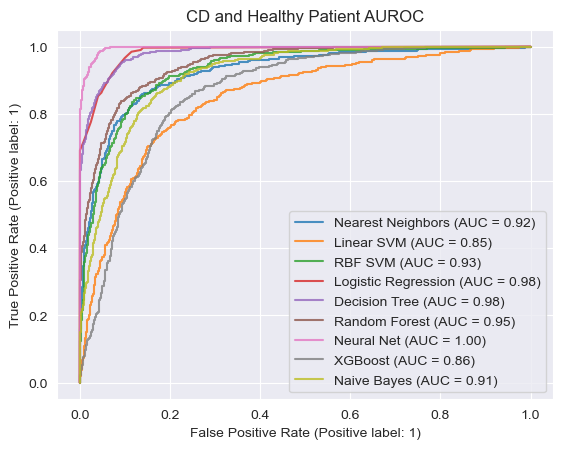

In [109]:
# CD and Healthy (with CRP)
fig_name_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/cd_healthy_models.png'
plot_title = 'CD and Healthy Patient AUROC'
save_model_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/cd_vs_healthy_with_CRP/cd_vs_healthy_with_CRP'

test_models(cd_vs_healthy, plot_title, fig_name_path, save_model_path)

In [ ]:
# IBD and Healthy (no CRP)
crp_cols = ['crp1', 'crp2', 'crp3', 'crp4', 'crp5']

df = ibd_vs_healthy.drop(crp_cols, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/nocrp_healthy_ibd_models.png'
plot_title = 'IBD and Healthy Patient AUROC (no CRP)'
save_model_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/no_CRP_ibd_vs_healthy/no_CRP_ibd_vs_healthy'

test_models(df, plot_title, fig_name_path, save_model_path)

In [ ]:
# UC vs. CD (no CRP)

df = uc_vs_cd.drop(crp_cols, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/nocrp_cd_uc_models.png'
plot_title = 'CD and UC Patient AUROC (no CRP)'

test_models(df, plot_title, fig_name_path)

In [ ]:
# UC vs. Healthy (no CRP)

df = uc_vs_healthy.drop(crp_cols, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/nocrp_uc_healthy_models.png'
plot_title = 'UC and Healthy Patient AUROC (no CRP)'

test_models(df, plot_title, fig_name_path)

In [ ]:
# CD and Healthy (no CRP)

df = ibd_vs_healthy.drop(crp_cols, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/PROJECTS/ibd_ml_local/models/nocrp_cd_healthy_models.png'
plot_title = 'CD and Healthy Patient AUROC (no CRP)'

test_models(df, plot_title, fig_name_path)

### Models without Years 1-2 Prior to Diagnosis

In [ ]:
col_names = list(ibd_vs_healthy.columns.values)
remove_years = []

for c in col_names:
    if c[-1] == '1' or c[-1] == '2':
        remove_years.append(c)

crp_remove = ['crp3', 'crp4', 'crp5']
crp_and_years = remove_years + crp_remove

In [ ]:
# IBD vs. Healthy (with CRP)
df = ibd_vs_healthy.drop(remove_years, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/ibd_long_project/figures/model_figs/healthy_ibd_models_y35.png'
plot_title = 'IBD and Healthy Patient AUROC 3-5 Years Prior to Diagnosis'

test_models(df, plot_title, fig_name_path)

In [ ]:
# UC vs. CD (with CRP)
df = uc_vs_cd.drop(remove_years, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/ibd_long_project/figures/model_figs/cd_uc_models_y35.png'
plot_title = 'CD and UC Patient AUROC 3-5 Years Prior to Diagnosis'

test_models(df, plot_title, fig_name_path)

In [ ]:
# UC vs. Healthy (with CRP)
df = uc_vs_healthy.drop(remove_years, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/ibd_long_project/figures/model_figs/uc_healthy_models_y35.png'
plot_title = 'UC and Healthy Patient AUROC 3-5 Years Prior to Diagnosis'

test_models(uc_vs_healthy, plot_title, fig_name_path)

In [ ]:
# CD and Healthy (with CRP)
df = cd_vs_healthy.drop(remove_years, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/ibd_long_project/figures/model_figs/cd_healthy_models_y35.png'
plot_title = 'CD and Healthy Patient AUROC 3-5 Years Prior to Diagnosis'

test_models(df, plot_title, fig_name_path)

In [ ]:
# IBD and Healthy (no CRP)

df = ibd_vs_healthy.drop(crp_and_years, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/ibd_long_project/figures/model_figs/nocrp_healthy_ibd_models_y35.png'
plot_title = 'IBD and Healthy Patient AUROC (no CRP) 3-5 Years Prior to Diagnosis'

test_models(df, plot_title, fig_name_path)

In [ ]:
# UC vs. CD (no CRP)

df = uc_vs_cd.drop(crp_and_years, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/ibd_long_project/figures/model_figs/nocrp_cd_uc_models_y35.png'
plot_title = 'CD and UC Patient AUROC (no CRP) 3-5 Years Prior to Diagnosis'

test_models(df, plot_title, fig_name_path)

In [ ]:
# UC vs. Healthy (no CRP)

df = uc_vs_healthy.drop(crp_and_years, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/ibd_long_project/figures/model_figs/nocrp_uc_healthy_models_y35.png'
plot_title = 'UC and Healthy Patient AUROC (no CRP) 3-5 Years Prior to Diagnosis'

test_models(df, plot_title, fig_name_path)

In [ ]:
# CD and Healthy (no CRP)

df = ibd_vs_healthy.drop(crp_and_years, axis=1)
fig_name_path = '/Users/emmadyer/Desktop/ibd_long_project/figures/model_figs/nocrp_cd_healthy_models_y35.png'
plot_title = 'CD and Healthy Patient AUROC (no CRP) 3-5 Years Prior to Diagnosis'

test_models(df, plot_title, fig_name_path)

### Feature Importance for Years 3-5

In [ ]:
file_names = [
                'healthy_ibd',
                'cd_uc',
                'uc_healthy',
                'cd_healthy',
                'nocrp_healthy_ibd',
                'nocrp_cd_uc',
                'nocrp_uc_healthy',
                'nocrp_cd_healthy']

barplot_titles = [
                    'Healthy vs. IBD Patient RFC Model Feature Importance: Years 3-5 Prior to Diagnosis (with CRP)',
                    'CD vs. UC Patient RFC Model Feature Importance: Years 3-5 Prior to Diagnosis (with CRP)',
                    'UC vs. Healthy Patient RFC Model Feature Importance: Years 3-5 Prior to Diagnosis (with CRP)',
                    'CD vs. Healthy Patient RFC Model Feature Importance: Years 3-5 Prior to Diagnosis (with CRP)',
                    'Healthy vs. IBD Patient RFC Model Feature Importance: Years 3-5 Prior to Diagnosis (no CRP)',
                    'CD vs. UC Patient RFC Model Feature Importance: Years 3-5 Prior to Diagnosis (no CRP)',
                    'UC vs. Healthy Patient RFC Model Feature Importance: Years 3-5 Prior to Diagnosis (no CRP)',
                    'CD vs. Healthy Patient RFC Model Feature Importance: Years 3-5 Prior to Diagnosis (no CRP)']

def get_feature_barplot(df, img_name, barplot_title, color):
    X = df.iloc[:, :-1]
    X = X.fillna(0)
    y = df.loc[:, 'ibd_disease_code']
    X_col_names = list(df.columns.values)
    X_col_names = X_col_names[:-1]
    y_col_name = ['disease_code']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42)

    rfc = RandomForestClassifier(random_state=42, n_estimators=160, max_features=5, max_depth=5, min_samples_leaf=10)
    rfc.fit(X_train, y_train)

    feat_imp_df = pd.DataFrame({'feature': X_col_names
                                ,'importance': rfc.feature_importances_})\
                                .sort_values('importance', ascending=False)

    sns.set_style('darkgrid')
    plt.figure(figsize=(10, 6))
    important_feats = feat_imp_df.sort_values('importance', ascending=False).reset_index()
    important_feats = important_feats.loc[:25, :]
    l = sns.barplot(x=important_feats['importance']
                , y=important_feats['feature']
                , color=color).set(ylabel= "Feature", xlabel= "Importance", title=barplot_title)
    img_path = '/Users/emmadyer/Desktop/ibd_long_project/figures/tree_feature_barplots/' + img_name + '.png'
    plt.savefig(img_path, dpi=300)
    return

In [ ]:
# Prep dataframes
y35_ibd_vs_healthy = ibd_vs_healthy.drop(remove_years, axis=1)
y35_uc_vs_cd = uc_vs_cd.drop(remove_years, axis=1)
y35_uc_vs_healthy = uc_vs_healthy.drop(remove_years, axis=1)
y35_cd_vs_healthy = cd_vs_healthy.drop(remove_years, axis=1)
y35_nocrp_ibd_vs_healthy = ibd_vs_healthy.drop(crp_and_years, axis=1)
y35_nocrp_uc_vs_cd = uc_vs_cd.drop(crp_and_years, axis=1)
y35_nocrp_uc_vs_healthy = uc_vs_healthy.drop(crp_and_years, axis=1)
y35_nocrp_cd_vs_healthy = cd_vs_healthy.drop(crp_and_years, axis=1)

y35_dfs = [y35_ibd_vs_healthy,
            y35_uc_vs_cd,
            y35_uc_vs_healthy,
            y35_cd_vs_healthy,
            y35_nocrp_ibd_vs_healthy,
            y35_nocrp_uc_vs_cd,
            y35_nocrp_uc_vs_healthy,
            y35_nocrp_cd_vs_healthy] 

colors = ['purple', 'green', 'blue', 'pink', 'purple', 'green', 'blue', 'pink']

for i, df in enumerate(y35_dfs):
    img_name = file_names[i] + 'y35_barplot'
    barplot_title = barplot_titles[i]
    color = colors[i]
    get_feature_barplot(df, img_name, barplot_title, color)


#### UMAP of the Datasets

In [ ]:
import umap.umap_ as umap
from sklearn.decomposition import PCA
import sklearn.cluster as cluster
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

In [ ]:
healthy_ibd_reducer = umap.UMAP()

healthy_ibd = ibd_vs_healthy.iloc[:, :-1]
em_healthy_ibd = healthy_ibd_reducer.fit_transform(healthy_ibd)
em_healthy_ibd.shape

In [ ]:
plt.scatter(
    em_healthy_ibd[:, 0],
    em_healthy_ibd[:, 1],
    c = [sns.color_palette('husl')[x] for x in ibd_vs_healthy.ibd_disease_code.map({0:0, 1:1})],
    s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP of Healthy and IBD Patients', fontsize=16)
plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/healthy_ibd_UMAP', dpi=300)

In [ ]:
uc_cd_reducer = umap.UMAP()

uc_cd = uc_vs_cd.iloc[:, :-1]
em_uc_cd = uc_cd_reducer.fit_transform(uc_cd)
em_uc_cd.shape

In [ ]:
l = plt.scatter(
    em_uc_cd[:, 0],
    em_uc_cd[:, 1],
    c = [sns.color_palette('husl')[x] for x in uc_vs_cd.ibd_disease_code.map({0:0, 1:1})],
    s=2)
plt.gca().set_aspect('equal', 'datalim')
plt.legend(['CD'])
plt.title('UMAP of UC and CD Patients', fontsize=16)
plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/cd_uc_UMAP', dpi=300)

In [ ]:
# Supervised UMAP
uc_cd_reducer = umap.UMAP(densmap=True, random_state=42)

uc_cd = uc_vs_cd.iloc[:, :-1]
target = uc_vs_cd.loc[:, 'ibd_disease_code']
em_uc_cd = uc_cd_reducer.fit_transform(uc_cd, y=target)

plt.scatter(
    em_uc_cd[:, 0],
    em_uc_cd[:, 1],
    c = uc_vs_cd.ibd_disease_code.astype(int),
    s=0.1)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP of UC and CD Patients', fontsize=16)
plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/cd_uc_umap.png', dpi=300)

In [ ]:
# Supervised UMAP
uc_cd_reducer = umap.UMAP(densmap=True, random_state=42)

uc_cd = uc_vs_cd.iloc[:, :-1]
target = uc_vs_cd.loc[:, 'ibd_disease_code']
em_uc_cd = uc_cd_reducer.fit_transform(uc_cd, y=target)

plt.scatter(
    em_uc_cd[:, 0],
    em_uc_cd[:, 1],
    c = uc_vs_cd.alb1.astype(int),
    s=0.1,
    cmap='plasma')
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP of UC and CD Patients', fontsize=16)
plt.colorbar()
#plt.savefig('/Users/emmadyer/Desktop/ibd_long_project/figures/cd_uc_umap.png', dpi=300)